<center><h1>Основы глубокого обучение</h1></center>

In [1]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Загрузка данных
ticker = "BTC-USD"
data = yf.download(ticker, start = "2020-01-01", end=pd.Timestamp.now().strftime("%Y-%m-%d"))
data = data[["Close"]]

# Нормализация данных
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data)

# Создание последовательностей
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Разделение данных
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


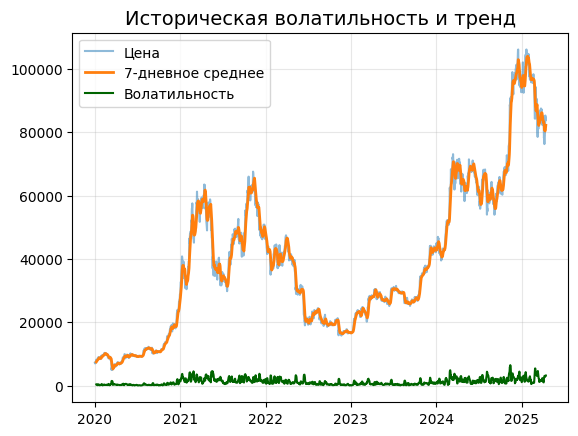

In [4]:
window_size = 7
data["MA_7"] = data["Close"].rolling(window = window_size).mean()
data["Volatility"] = data["Close"].rolling(window = window_size).std()
plt.plot(data["Close"], label = "Цена", alpha = 0.5)
plt.plot(data["MA_7"], label = "7-дневное среднее", linewidth = 2)
plt.plot(data["Volatility"], label = "Волатильность", color = "darkgreen")
plt.title("Историческая волатильность и тренд", fontsize = 14)
plt.legend()
plt.grid(alpha = 0.3)

In [5]:
def plot_analysis(
        loss_history,
        y_test_inv,
        test_predictions_inv,
        forecast_prices,
        model,
        is_lstm = False,
        description = "",
    ):
    # Создание единой фигуры с subplots
    plt.figure(figsize = (30, 20))
    plt.suptitle("Анализ работы Модели", y = 0.95, fontsize = 20)

    # 1. График обучения
    ax1 = plt.subplot2grid((4, 4), (0, 0), colspan = 2)
    ax1.plot(loss_history, color = "darkblue", linewidth = 2)
    ax1.set_title("Динамика обучения", fontsize = 14)
    ax1.set_xlabel("Эпоха", fontsize = 12)
    ax1.set_ylabel("Ошибка (MSE)", fontsize = 12)
    ax1.grid(True, alpha=0.3)

    # 2. Сравнение реальных и предсказанных значений
    errors = y_test_inv - test_predictions_inv # FIX: y_test -> y_test_inv 
    ax2 = plt.subplot2grid((4, 4), (0, 2))
    ax2.scatter(y_test_inv, test_predictions_inv, alpha = 0.5, c = np.abs(errors), cmap = "viridis")

    min_val = min(y_test_inv.min(), test_predictions_inv.min()) # or y_test_inv.min()
    max_val = max(y_test_inv.max(), test_predictions_inv.max()) # or y_test_inv.max()
    ax2.plot([min_val, max_val], [min_val, max_val], "--r", linewidth = 2)

    ax2.set_title("Реальные и предсказанные значения", fontsize = 14)
    ax2.set_xlabel("Реальная цена (USD)", fontsize = 12)
    ax2.set_ylabel("Предсказанная цена (USD)", fontsize = 12)
    ax2.grid(alpha = 0.3)

    # 3. Распределение ошибок
    ax3 = plt.subplot2grid((4, 4), (0, 3))
    ax3.hist(errors, bins = 30, color = "darkred", alpha = 0.7)
    ax3.set_title("Распределение ошибок", fontsize = 14)
    ax3.set_xlabel("Ошибка (USD)", fontsize = 12)
    ax3.set_ylabel("Частота", fontsize = 12)
    ax3.axvline(x = 0, color = "black", linestyle = "--")

    # 5. Примеры прогнозов
    ax5 = plt.subplot2grid((4, 4), (1, 0), colspan = 2)
    for i in range(3):
        idx = np.random.randint(len(X_test))
        seq = X_test[idx]

        if not is_lstm:
            pred = model.forward(seq.reshape(-1, 1))
        else:
            with torch.no_grad():
                pred = model(torch.FloatTensor(X_test[idx]).unsqueeze(0))

        ax5.plot(scaler.inverse_transform(seq), alpha = 0.5, linestyle = "--", label = f"Пример {i+1} - История")
        ax5.scatter(len(seq), y_test_inv[idx].reshape(-1, 1), color = "red", zorder = 5)
        ax5.scatter(len(seq), scaler.inverse_transform(pred), color = "green", zorder = 5, label = f"Пример {i+1} - Прогноз")
    ax5.set_title("Примеры прогнозов", fontsize = 14)
    ax5.set_xlabel("День", fontsize = 12)
    ax5.set_ylabel("Цена (USD)", fontsize = 12)
    ax5.legend()

    # 6. Важность временных лагов
    ax6 = plt.subplot2grid((4, 4), (1, 2))
    
    if not is_lstm:
        weights = model.W_xh
    else:
        weights = model.inner_model.weight_ih_l0.detach().numpy()[:model.hidden_size]

    lag_importance = np.mean(np.abs(weights), axis = 0)
    ax6.bar(range(seq_length), lag_importance[:seq_length], color = plt.cm.viridis(np.linspace(0, 1, seq_length)))

    ax6.set_title("Важность временных лагов", fontsize = 14)
    ax6.set_xlabel("Лаг (дни назад)", fontsize = 12)
    ax6.set_ylabel("Важность (|W_xh|)", fontsize = 12)

    # 7. Автокорреляция ошибок
    ax7 = plt.subplot2grid((4, 4), (1, 3))
    pd.plotting.autocorrelation_plot(errors.flatten(), ax = ax7)
    ax7.set_title("Автокорреляция ошибок", fontsize = 14)
    ax7.set_xlabel("Лаг", fontsize = 12)
    ax7.set_ylabel("Корреляция", fontsize = 12)
    ax7.grid(alpha = 0.3)

    # 8. Долгосрочный прогноз
    ax8 = plt.subplot2grid((4, 4), (2, 0), colspan = 2)
    forecast_dates = pd.date_range(start = data.index[-1], periods = 31)[1:]
    ax8.plot(forecast_dates, forecast_prices, marker = "o", markersize = 6, linestyle = "-", color = "darkorange")
    ax8.set_title("30-дневный прогноз", fontsize = 14)
    ax8.xaxis.set_major_formatter(mdates.DateFormatter("%d %b %Y"))
    ax8.xaxis.set_major_locator(mdates.DayLocator(interval = 5))
    plt.setp(ax8.get_xticklabels(), rotation = 45, ha = "right")
    ax8.grid(True, alpha = 0.3)

    # 10. Распределение весов
    ax10 = plt.subplot2grid((4, 4), (2, 2))
    if not is_lstm:
        all_weights = np.concatenate([model.W_xh.flatten(), model.W_hh.flatten()])
    else:
        all_weights = []
        for param in model.parameters():
            if param.requires_grad:
                all_weights.extend(param.detach().numpy().flatten())
    ax10.hist(all_weights, bins = 50, color = "teal", alpha = 0.7)
    ax10.set_title("Распределение весов модели", fontsize = 14)
    ax10.set_xlabel("Значение веса", fontsize = 12)
    ax10.set_ylabel("Частота", fontsize = 12)
    ax10.grid(True, alpha = 0.3)

    # 11. Легенда модели
    ax11 = plt.subplot2grid((4, 4), (2, 3))
    ax11.axis("off")
    ax11.text(0.1, 0.5, description, fontsize = 12, va = "center", bbox = dict(facecolor = "white", alpha = 0.5))

    plt.tight_layout(rect = [0, 0, 1, 0.93])
    plt.show()

In [6]:
# Параметры моделей
input_size = 1
hidden_size = 32
lr = 0.001
epochs = 100

In [7]:
# Реализация RNN
class SimpleRNN:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_xh = np.random.randn(hidden_size, input_size) * 0.01
        self.W_hh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.b_h = np.zeros((hidden_size, 1))
        self.W_hy = np.random.randn(1, hidden_size) * 0.01
        self.b_y = np.zeros((1, 1))
    
    def forward(self, inputs):
        h_prev = np.zeros((self.W_hh.shape[0], 1))
        self.hs = [h_prev]
        self.outputs = []
        for x in inputs:
            x = x.reshape(-1, 1)
            h = np.tanh(self.W_xh @ x + self.W_hh @ h_prev + self.b_h)
            y = self.W_hy @ h + self.b_y
            self.hs.append(h)
            self.outputs.append(y)
            h_prev = h
        return self.outputs[-1]
    
    def backward(self, inputs, target, lr=0.001, truncate_steps: int | None = None, clip_norm: float | None = None):  # Изменение 1: Добавлен параметры
        dW_xh, dW_hh, db_h = 0, 0, 0
        dW_hy, db_y = 0, 0
        dh_next = np.zeros_like(self.hs[0])
        
        dy = (self.outputs[-1] - target.reshape(-1, 1))
        dW_hy += dy @ self.hs[-1].T
        db_y += dy
        
        dh = self.W_hy.T @ dy + dh_next #ISSUE: dh should be initialized with only last prediction

        # Изменение 2: Ограничение диапазона шагов для BPTT
        start_step = max(0, len(inputs) - truncate_steps) if truncate_steps is not None else 0
        for t in reversed(range(start_step, len(inputs))): # Только последние truncate_steps шагов
            x = inputs[t].reshape(-1, 1)
            h_current = self.hs[t+1]
            h_prev = self.hs[t]
            
            dtanh = (1 - h_current ** 2) * dh
            dW_xh += dtanh @ x.T
            dW_hh += dtanh @ h_prev.T
            db_h += dtanh
            
            dh = self.W_hh.T @ dtanh #ISSUE: additional dLt / dyt * W_hy.T is required here
            
        # Изменение 3: Gradient Clipping по L2-норме
        if clip_norm is not None:
            grads = [dW_xh, dW_hh, db_h, dW_hy, db_y]
            global_norm = np.sqrt(sum(np.sum(g**2) for g in grads)) # Подсчет общей нормы
            
            if global_norm > clip_norm:
                scale = clip_norm / global_norm
                for g in grads:
                    g *= scale # Масштабирование всех градиентов
        else:
            clip_value = 5.0
            for grad in [dW_xh, dW_hh, dW_hy]:
                np.clip(grad, -clip_value, clip_value, out = grad)
        
        self.W_xh -= lr * dW_xh
        self.W_hh -= lr * dW_hh
        self.b_h -= lr * db_h
        self.W_hy -= lr * dW_hy
        self.b_y -= lr * db_y


In [12]:
def train_and_visualize(model, description, truncate_steps: int | None = None, clip_norm: float | None = None, is_lstm: bool = False):

    assert not (is_lstm and (truncate_steps is not None or clip_norm is not None)), "truncate_steps and clip_norm are not supported for LSTM"
    
    criterion = nn.MSELoss()
    if is_lstm:
        optimizer = optim.Adam(model.parameters(), lr = 0.001) # Wouldn't be used for SimpleRNN

    # Обучение модели
    if is_lstm:
        model.train()

    loss_history = []
    board = tqdm(range(epochs), desc = "Обучение модели", unit = "эпоха")
    for _ in board:
        epoch_loss = 0

        if is_lstm:
            for i in range(len(X_train)):
                inputs = torch.tensor(X_train[i], dtype=torch.float32).unsqueeze(0).to(device=device)
                target = torch.tensor(y_train[i], dtype=torch.float32).unsqueeze(0).to(device=device)
        
                optimizer.zero_grad()
                output = model(inputs, device)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
        else:
            for i in range(len(X_train)):
                inputs = X_train[i].reshape(-1, 1)
                target = y_train[i].reshape(-1, 1)
                
                output = model.forward(inputs)
                loss = (output - target) ** 2

                epoch_loss += loss.item()
                
                model.backward(inputs, target, lr, truncate_steps, clip_norm)
        
        avg_loss = epoch_loss / len(X_train)
        loss_history.append(avg_loss)

        board.set_postfix(loss = avg_loss)

    # Функция прогнозирования
    def forecast(model, last_sequence, days = 30):
        predictions = []
        if is_lstm:
            current_seq = torch.FloatTensor(last_sequence)
        else:
            current_seq = last_sequence.copy()
        for _ in range(days):
            if is_lstm:
                next_pred = model(current_seq.unsqueeze(0))
                predictions.append(next_pred.item())
                current_seq = torch.cat((current_seq[1:], next_pred))
            else:
                next_pred = model.forward(current_seq)
                predictions.append(next_pred.item())
                current_seq = np.append(current_seq[1:], next_pred)
        return predictions

    # Генерация предсказаний на тестовых данных
    if is_lstm:
        model.eval()
        model = model.to(device=torch.device("cpu"))
    
    test_predictions = []
    if is_lstm:
        with torch.no_grad():
            for seq in X_test:
                inputs = torch.tensor(seq, dtype=torch.float32).unsqueeze(0)
                pred = model(inputs)
                test_predictions.append(pred.item())
    else:
        for i in range(len(X_test)):
            inputs = X_test[i].reshape(-1, 1)
            output = model.forward(inputs)
            test_predictions.append(output.item())

    # Преобразование предсказаний обратно в исходный масштаб цен
    test_predictions_inv = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Прогноз на N дней 
    last_sequence = scaled_data[-seq_length:]
    if not is_lstm:
        last_sequence = last_sequence.reshape(-1, 1)
    scaled_forecast = forecast(model, last_sequence, days = 30)
    forecast_prices = scaler.inverse_transform(np.array(scaled_forecast).reshape(-1, 1))

    plot_analysis(
        loss_history,
        y_test_inv,
        test_predictions_inv,
        forecast_prices,
        model,
        is_lstm=is_lstm,
        description=description
    )

Обучение модели: 100%|██████████| 100/100 [01:59<00:00,  1.20s/эпоха, loss=0.000243]


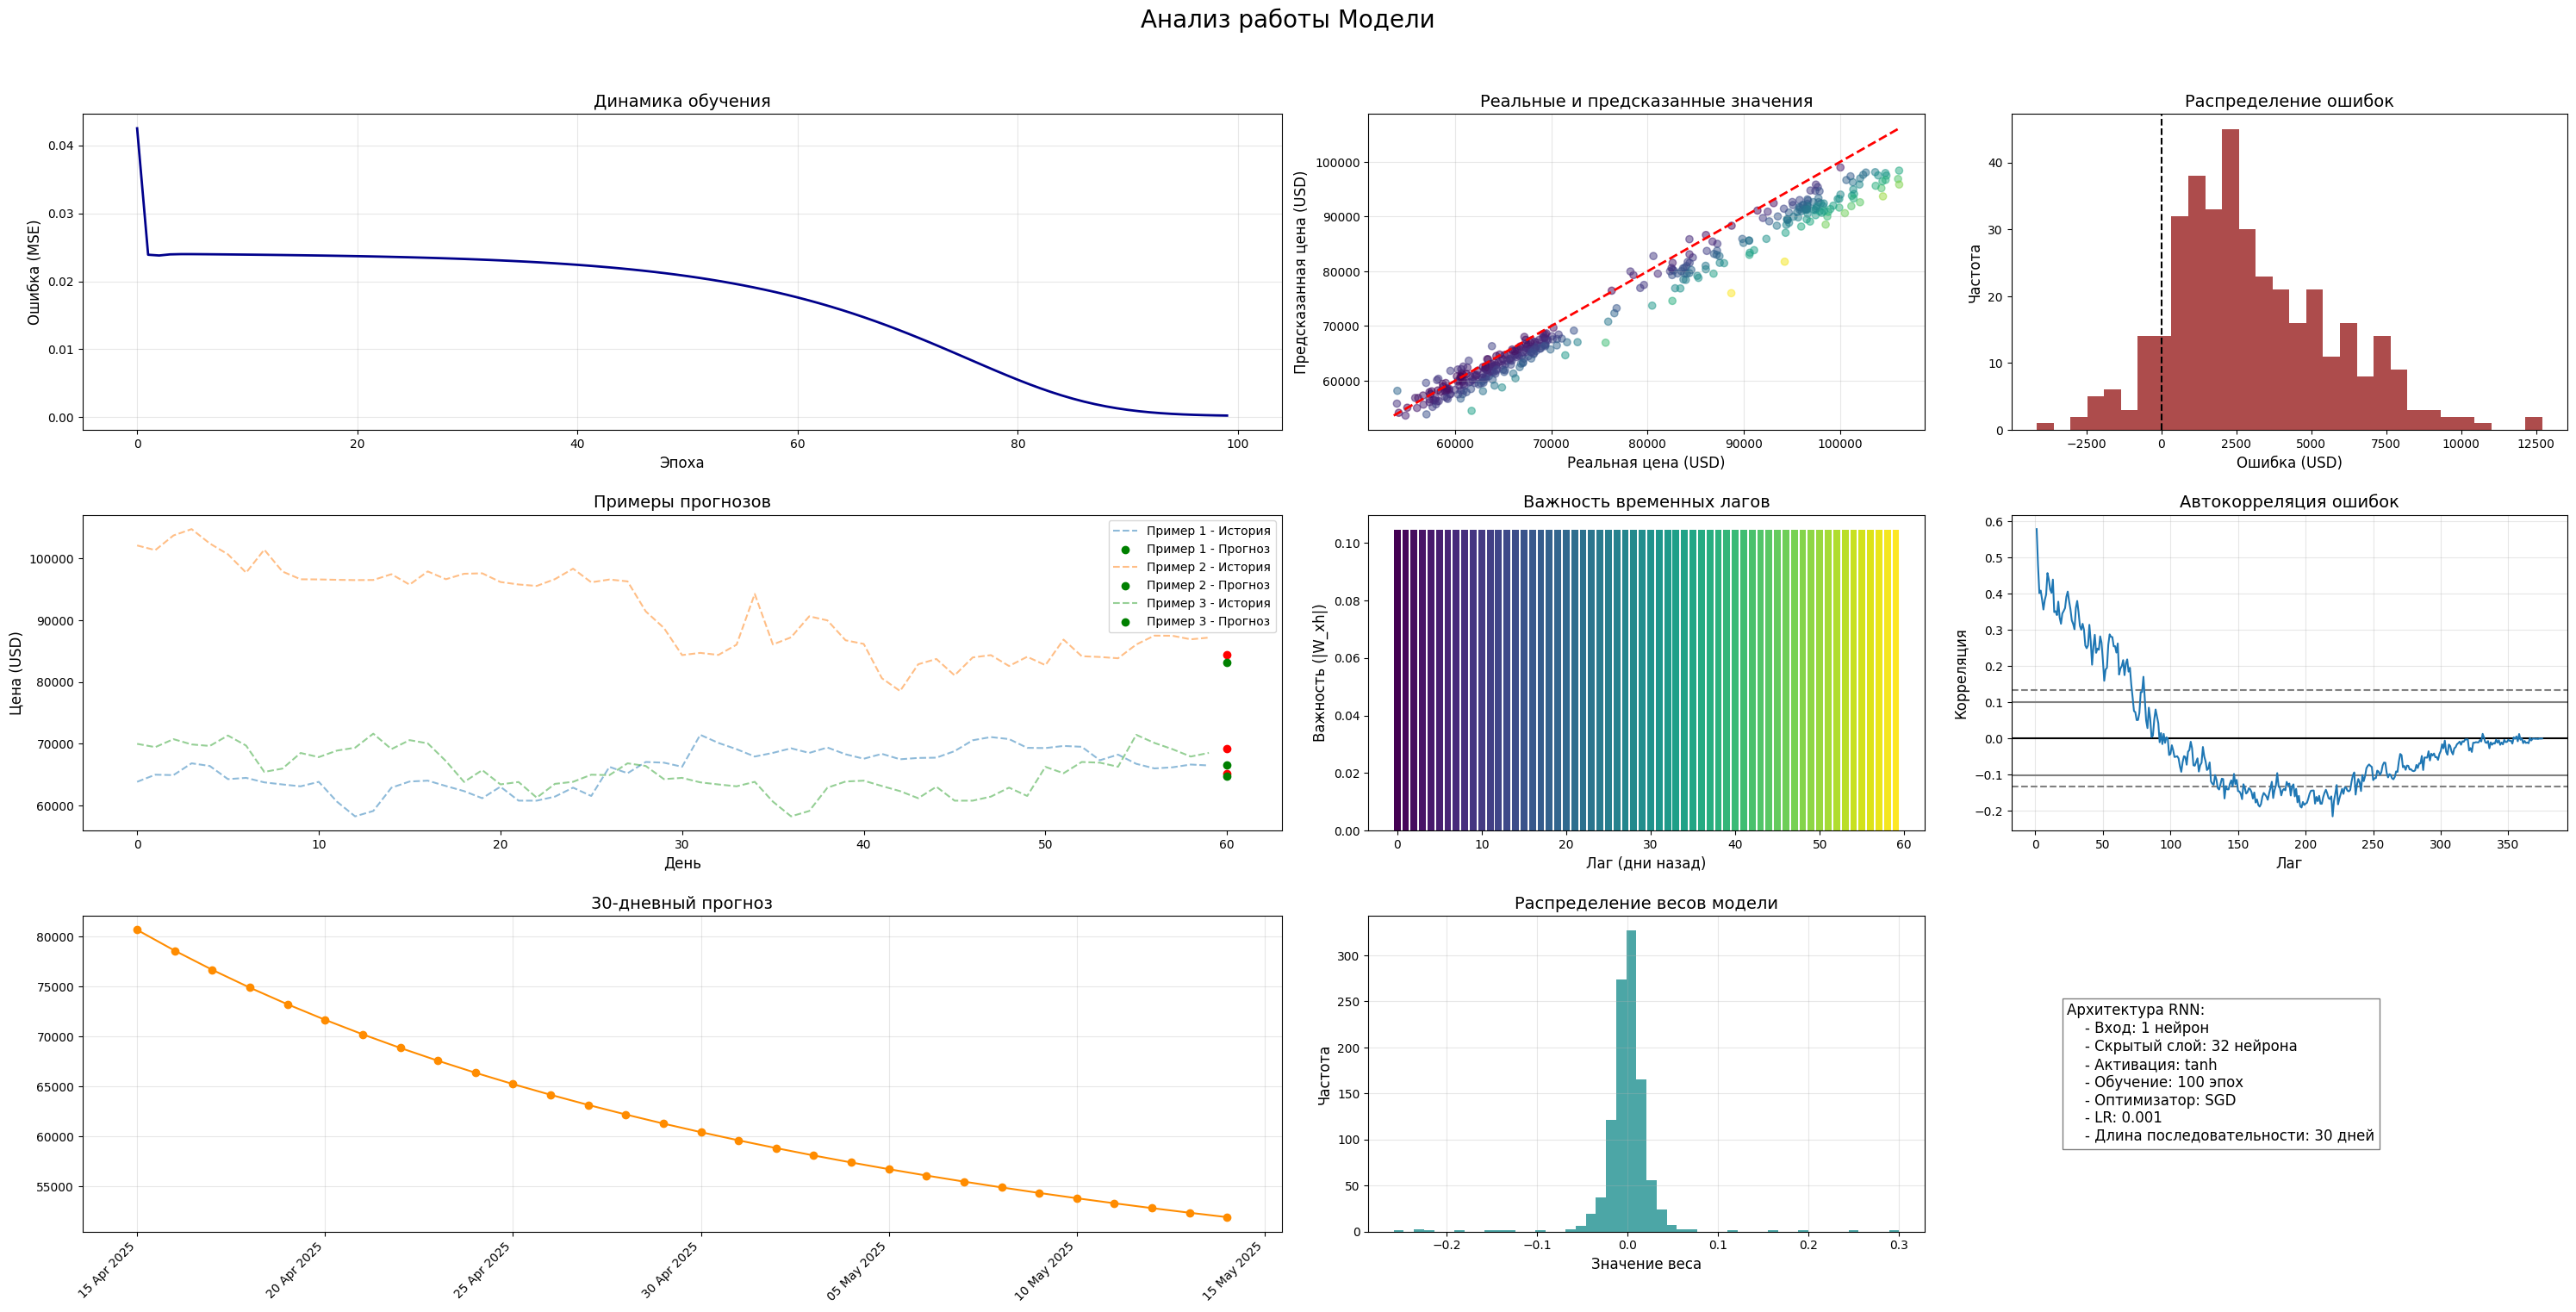

In [13]:
rnn = SimpleRNN(input_size, hidden_size)

train_and_visualize(rnn, description=f"""Архитектура RNN:
    - Вход: 1 нейрон
    - Скрытый слой: {rnn.hidden_size} нейрона
    - Активация: tanh
    - Обучение: {epochs} эпох
    - Оптимизатор: SGD
    - LR: {lr}
    - Длина последовательности: 30 дней"""
)

### Использование усеченного BPTT (Truncated BPTT)

Обучение модели: 100%|██████████| 100/100 [01:03<00:00,  1.58эпоха/s, loss=0.000242]


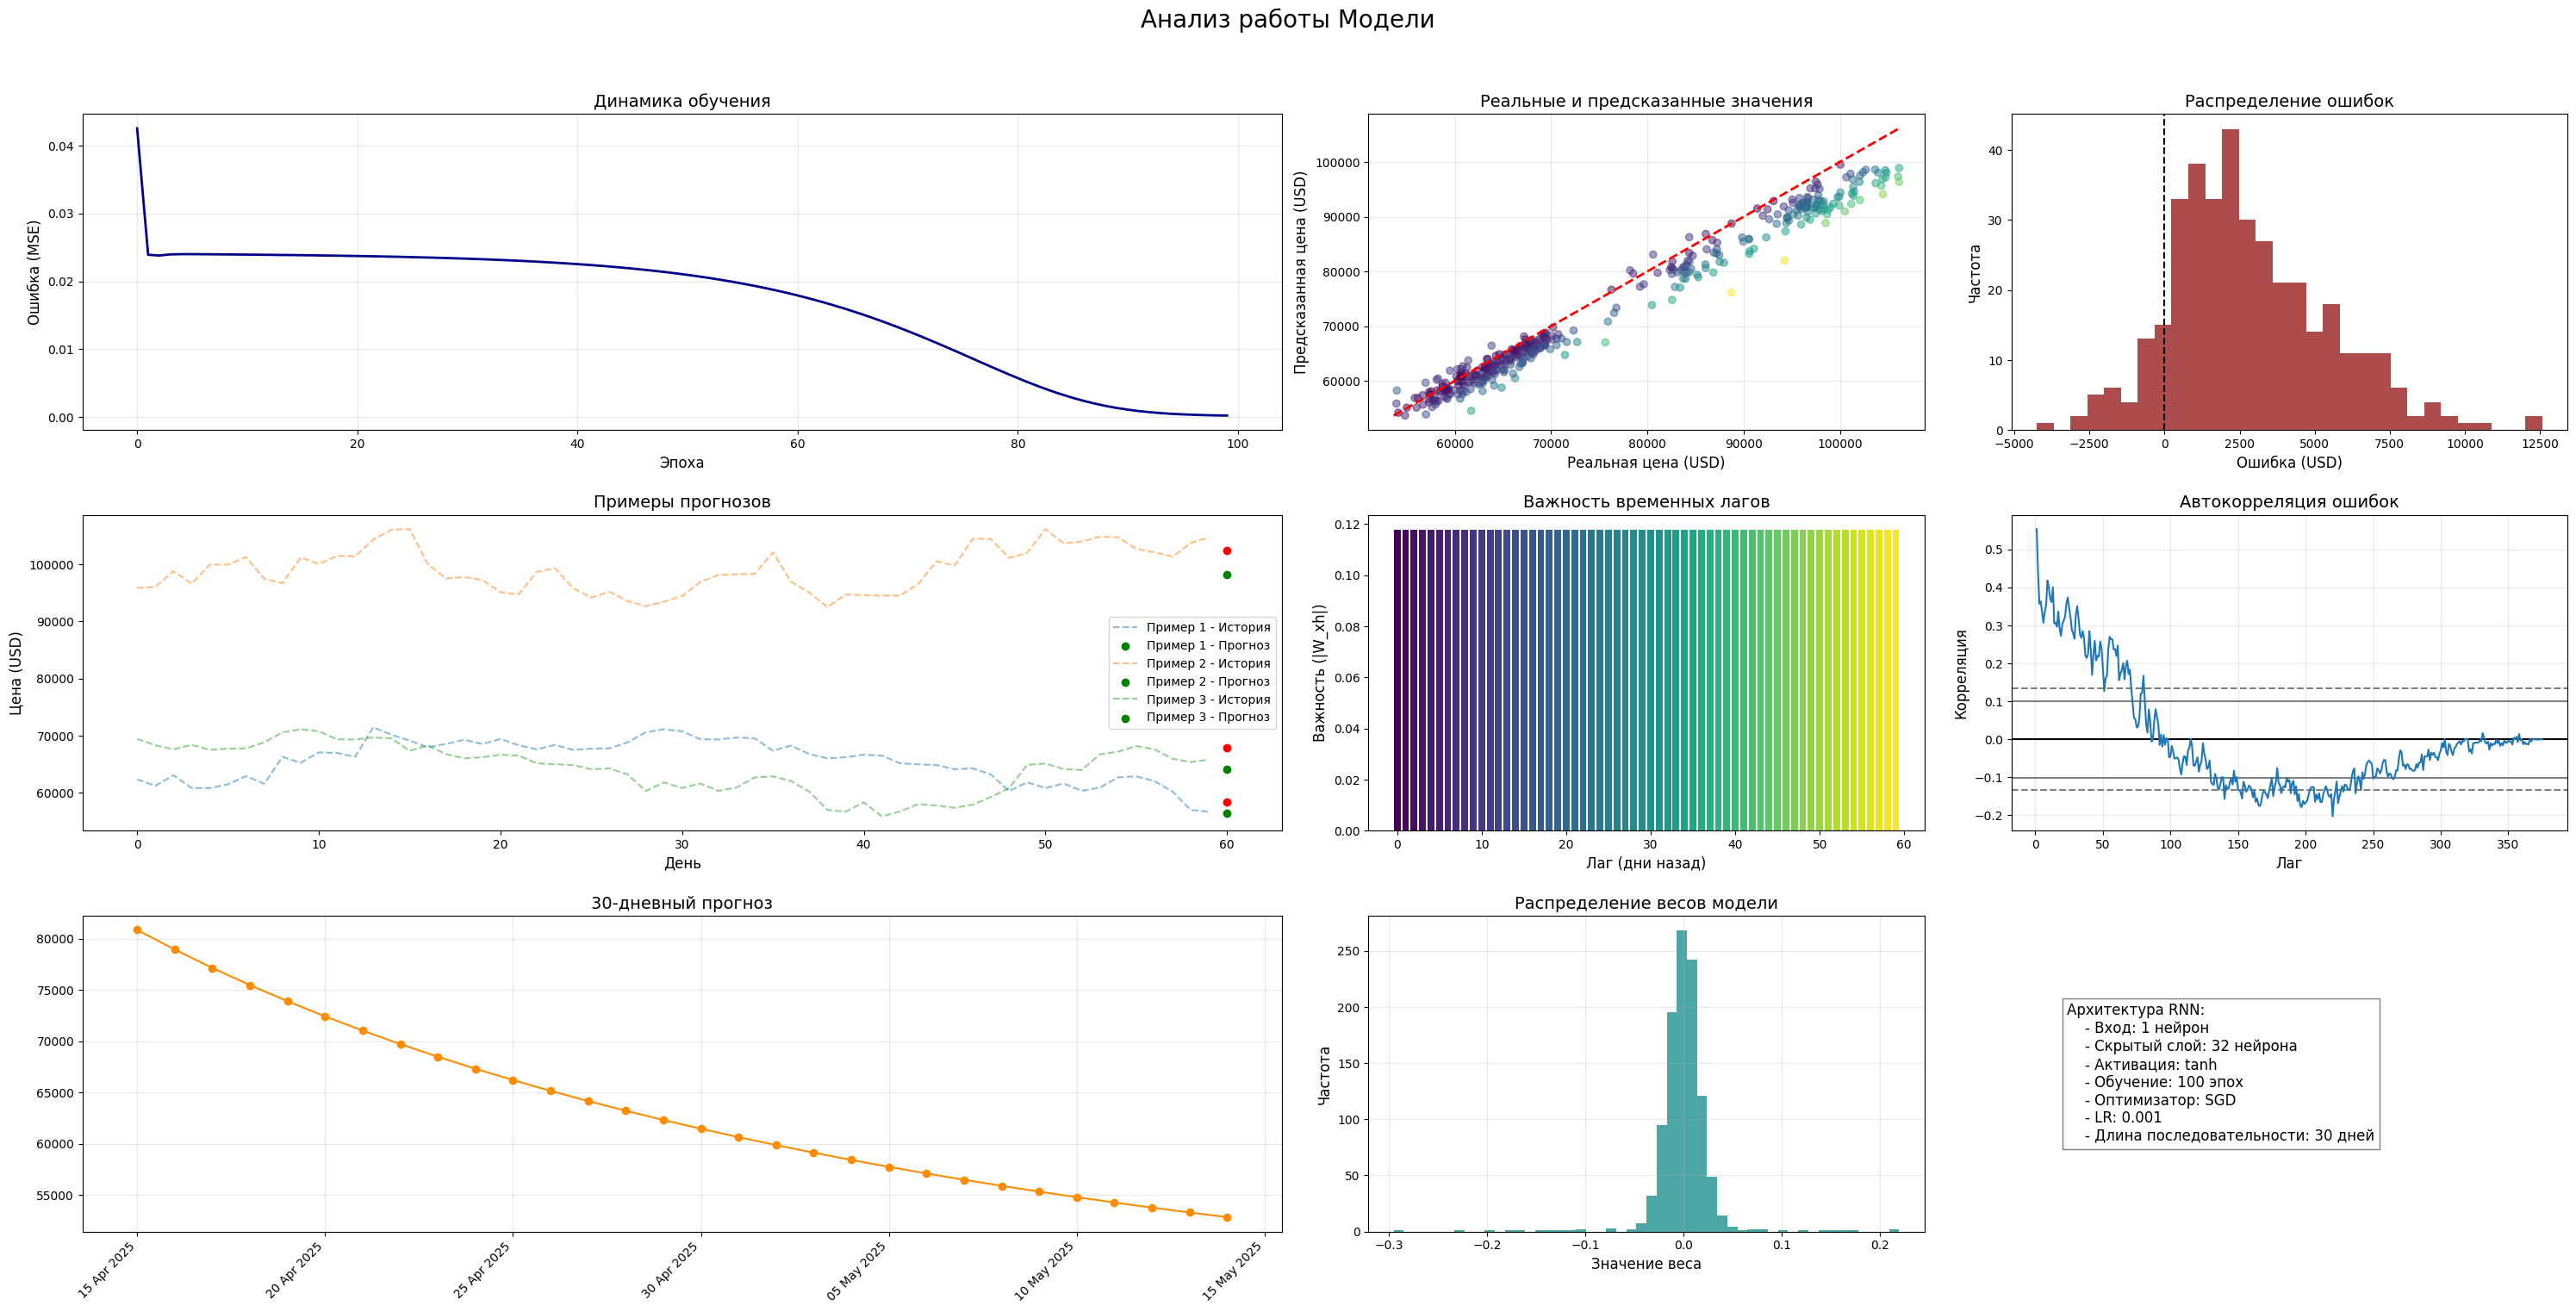

In [14]:
rnn = SimpleRNN(input_size, hidden_size)

train_and_visualize(rnn, description=f"""Архитектура RNN:
    - Вход: 1 нейрон
    - Скрытый слой: {rnn.hidden_size} нейрона
    - Активация: tanh
    - Обучение: {epochs} эпох
    - Оптимизатор: SGD
    - LR: {lr}
    - Длина последовательности: 30 дней"""
, truncate_steps=10)

### Нормализация градиентов

Обучение модели: 100%|██████████| 100/100 [02:05<00:00,  1.26s/эпоха, loss=0.000238]


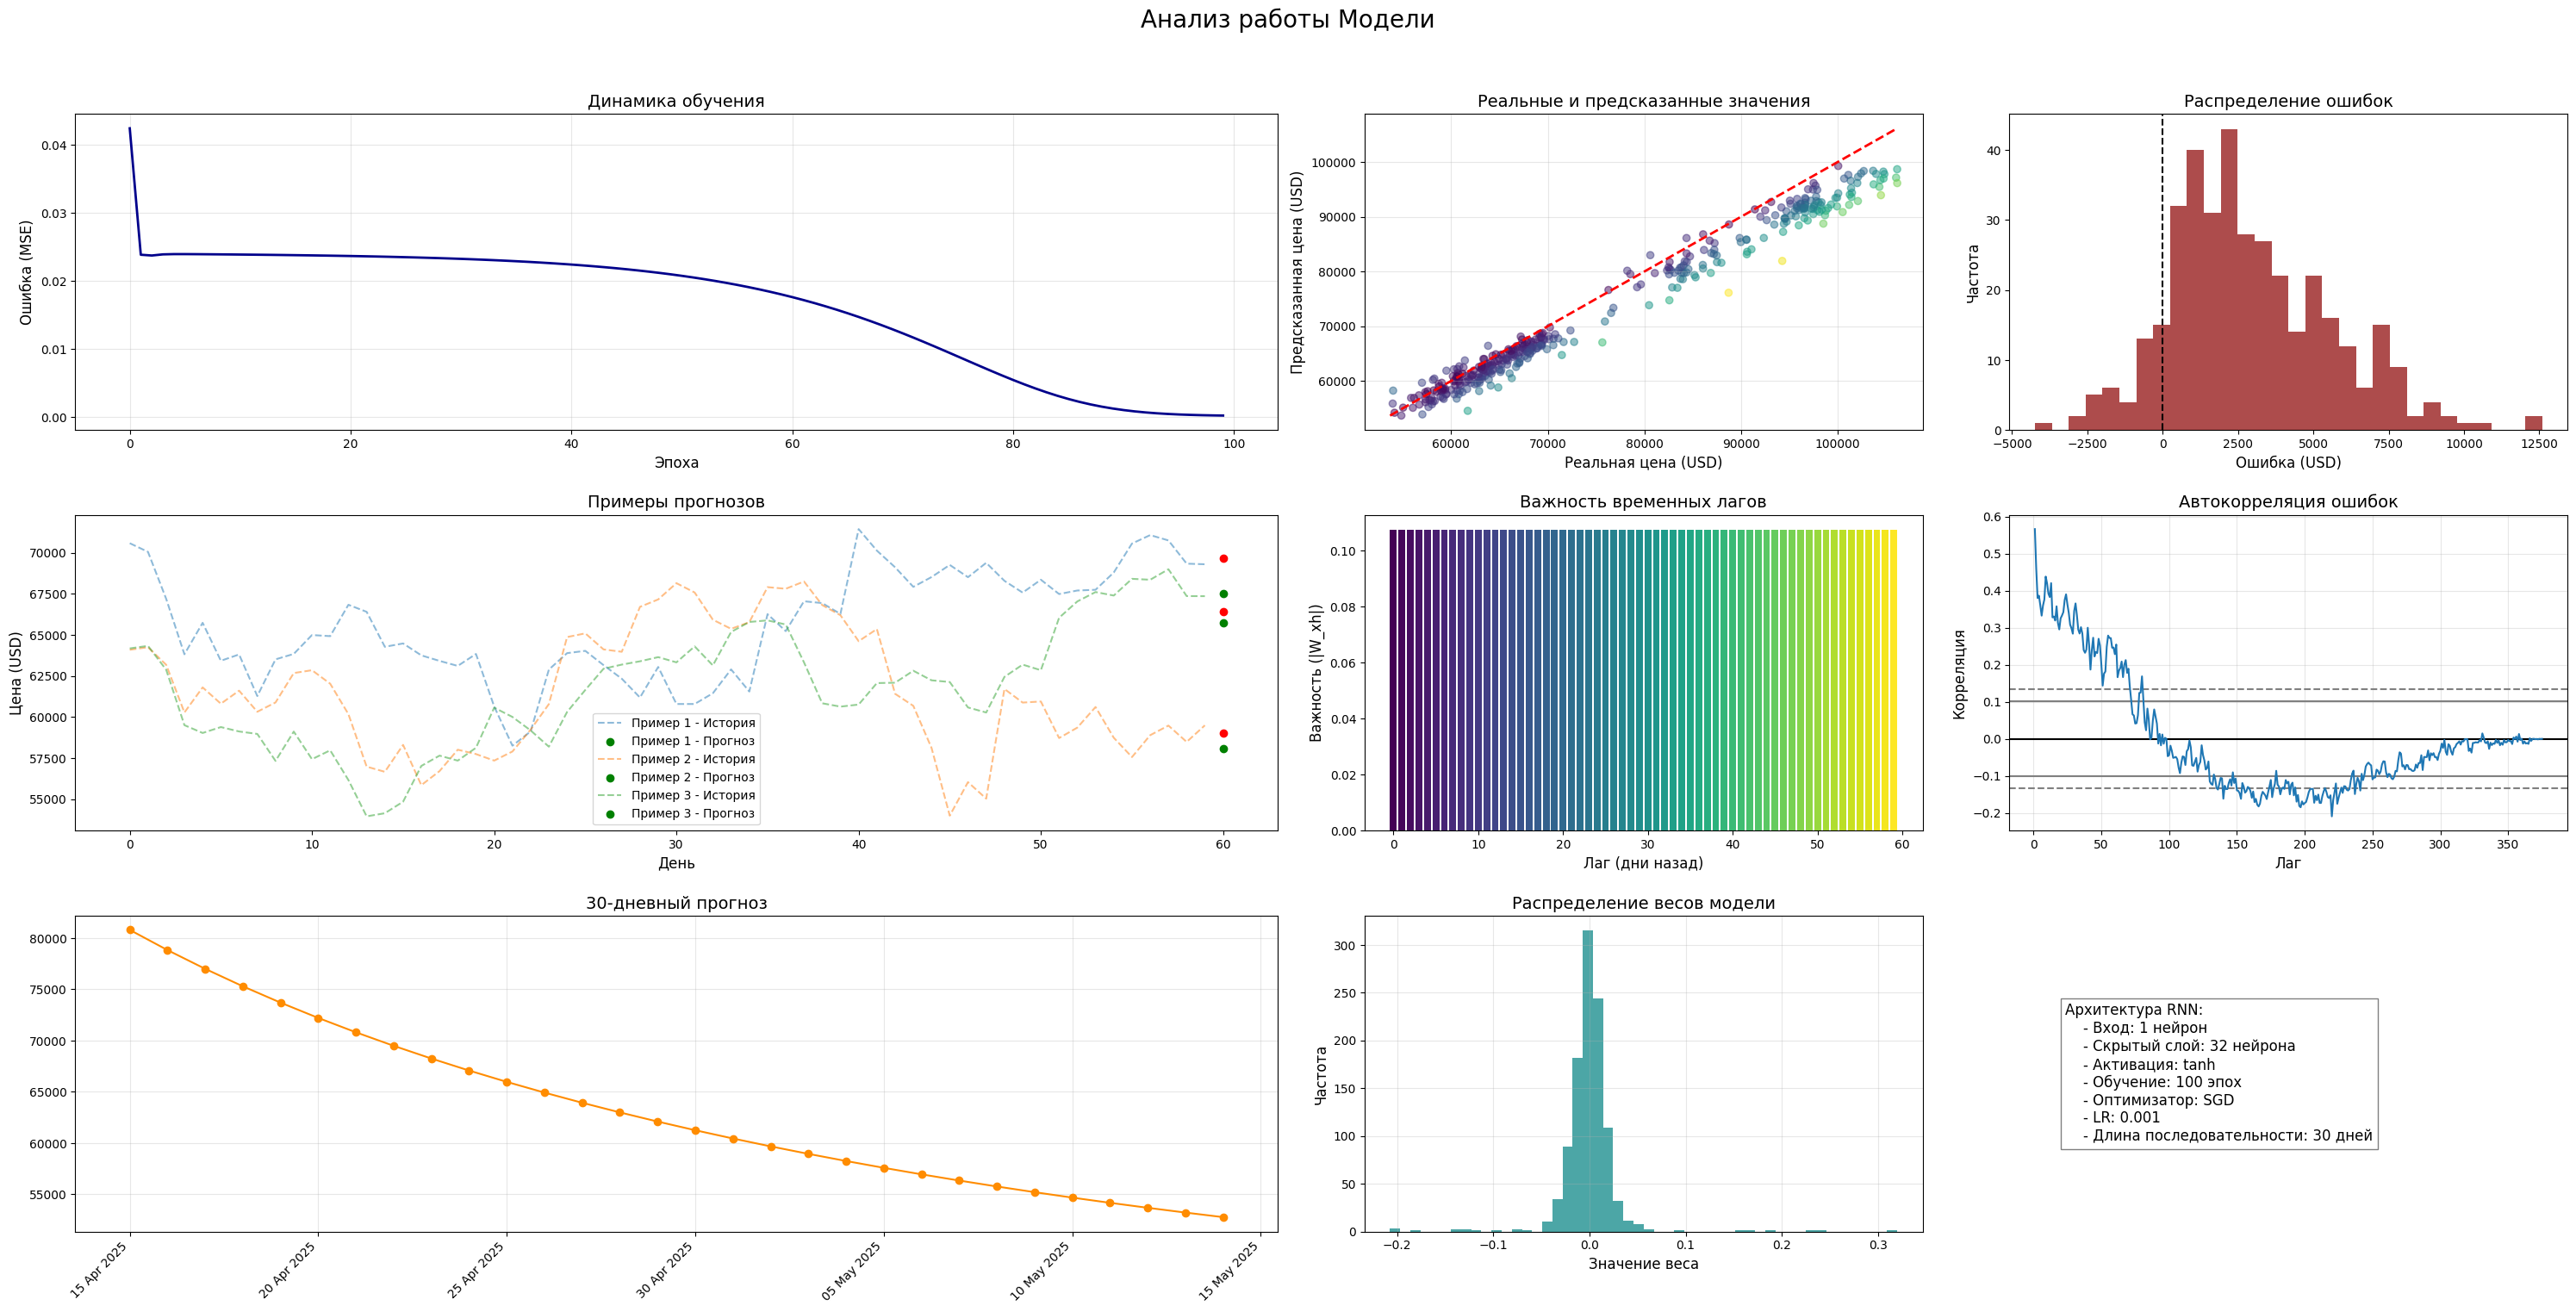

In [15]:
rnn = SimpleRNN(input_size, hidden_size)

train_and_visualize(rnn, description=f"""Архитектура RNN:
    - Вход: 1 нейрон
    - Скрытый слой: {rnn.hidden_size} нейрона
    - Активация: tanh
    - Обучение: {epochs} эпох
    - Оптимизатор: SGD
    - LR: {lr}
    - Длина последовательности: 30 дней"""
, clip_norm=5.0)

## Процесс обучения LSTM

Epoch 0, Loss: 0.000891
Epoch 10, Loss: 0.008166
Epoch 20, Loss: 0.006213
Epoch 30, Loss: 0.000627
Epoch 40, Loss: 0.000422
Epoch 50, Loss: 0.000341
Epoch 60, Loss: 0.000385
Epoch 70, Loss: 0.000298
Epoch 80, Loss: 0.000375
Epoch 90, Loss: 0.000401


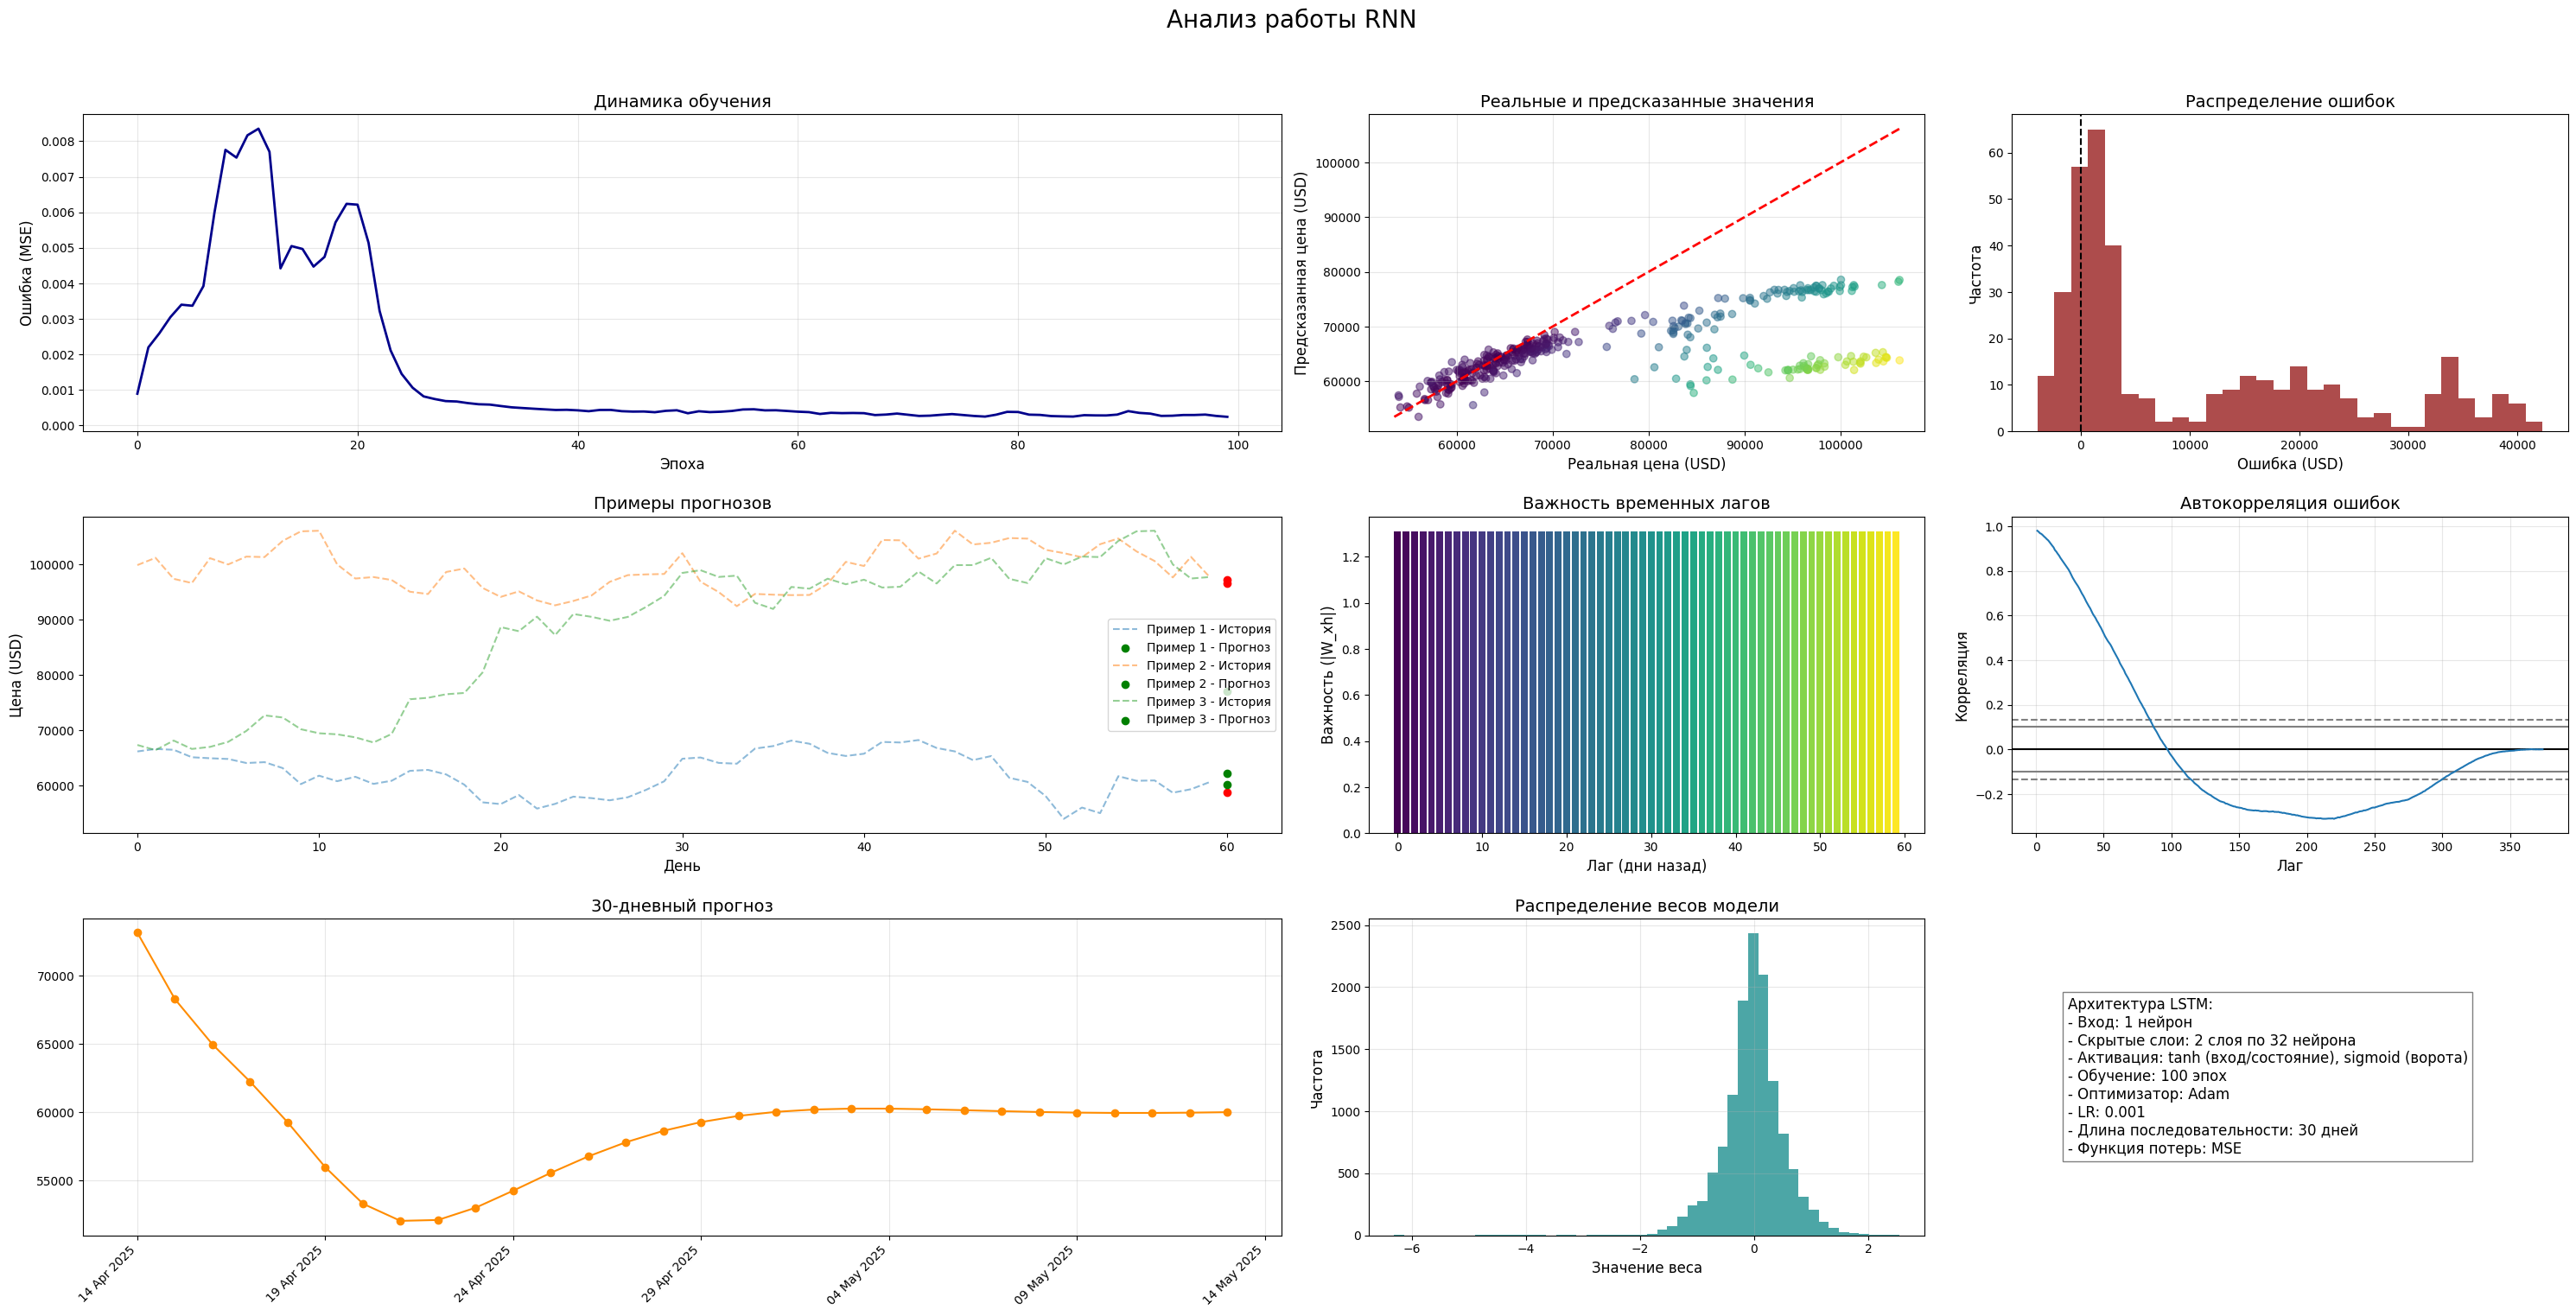

In [ ]:
# Определение LSTM модели
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.inner_model = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, device=torch.device("cpu")):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device).requires_grad_()
        out, (_, _) = self.inner_model(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinLSTM().to(device=device)

train_and_visualize(model, description=f"""Архитектура LSTM:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (вход/состояние), sigmoid (ворота)
- Обучение: {epochs} эпох
- Оптимизатор: Adam
- LR: {lr}
- Длина последовательности: 30 дней
- Функция потерь: MSE""", is_lstm=True)

## Процесс обучения GRU

Epoch 0, Loss: 0.000779
Epoch 10, Loss: 0.000280
Epoch 20, Loss: 0.000221
Epoch 30, Loss: 0.000239
Epoch 40, Loss: 0.000258
Epoch 50, Loss: 0.000231
Epoch 60, Loss: 0.000229
Epoch 70, Loss: 0.000219
Epoch 80, Loss: 0.000218
Epoch 90, Loss: 0.000205


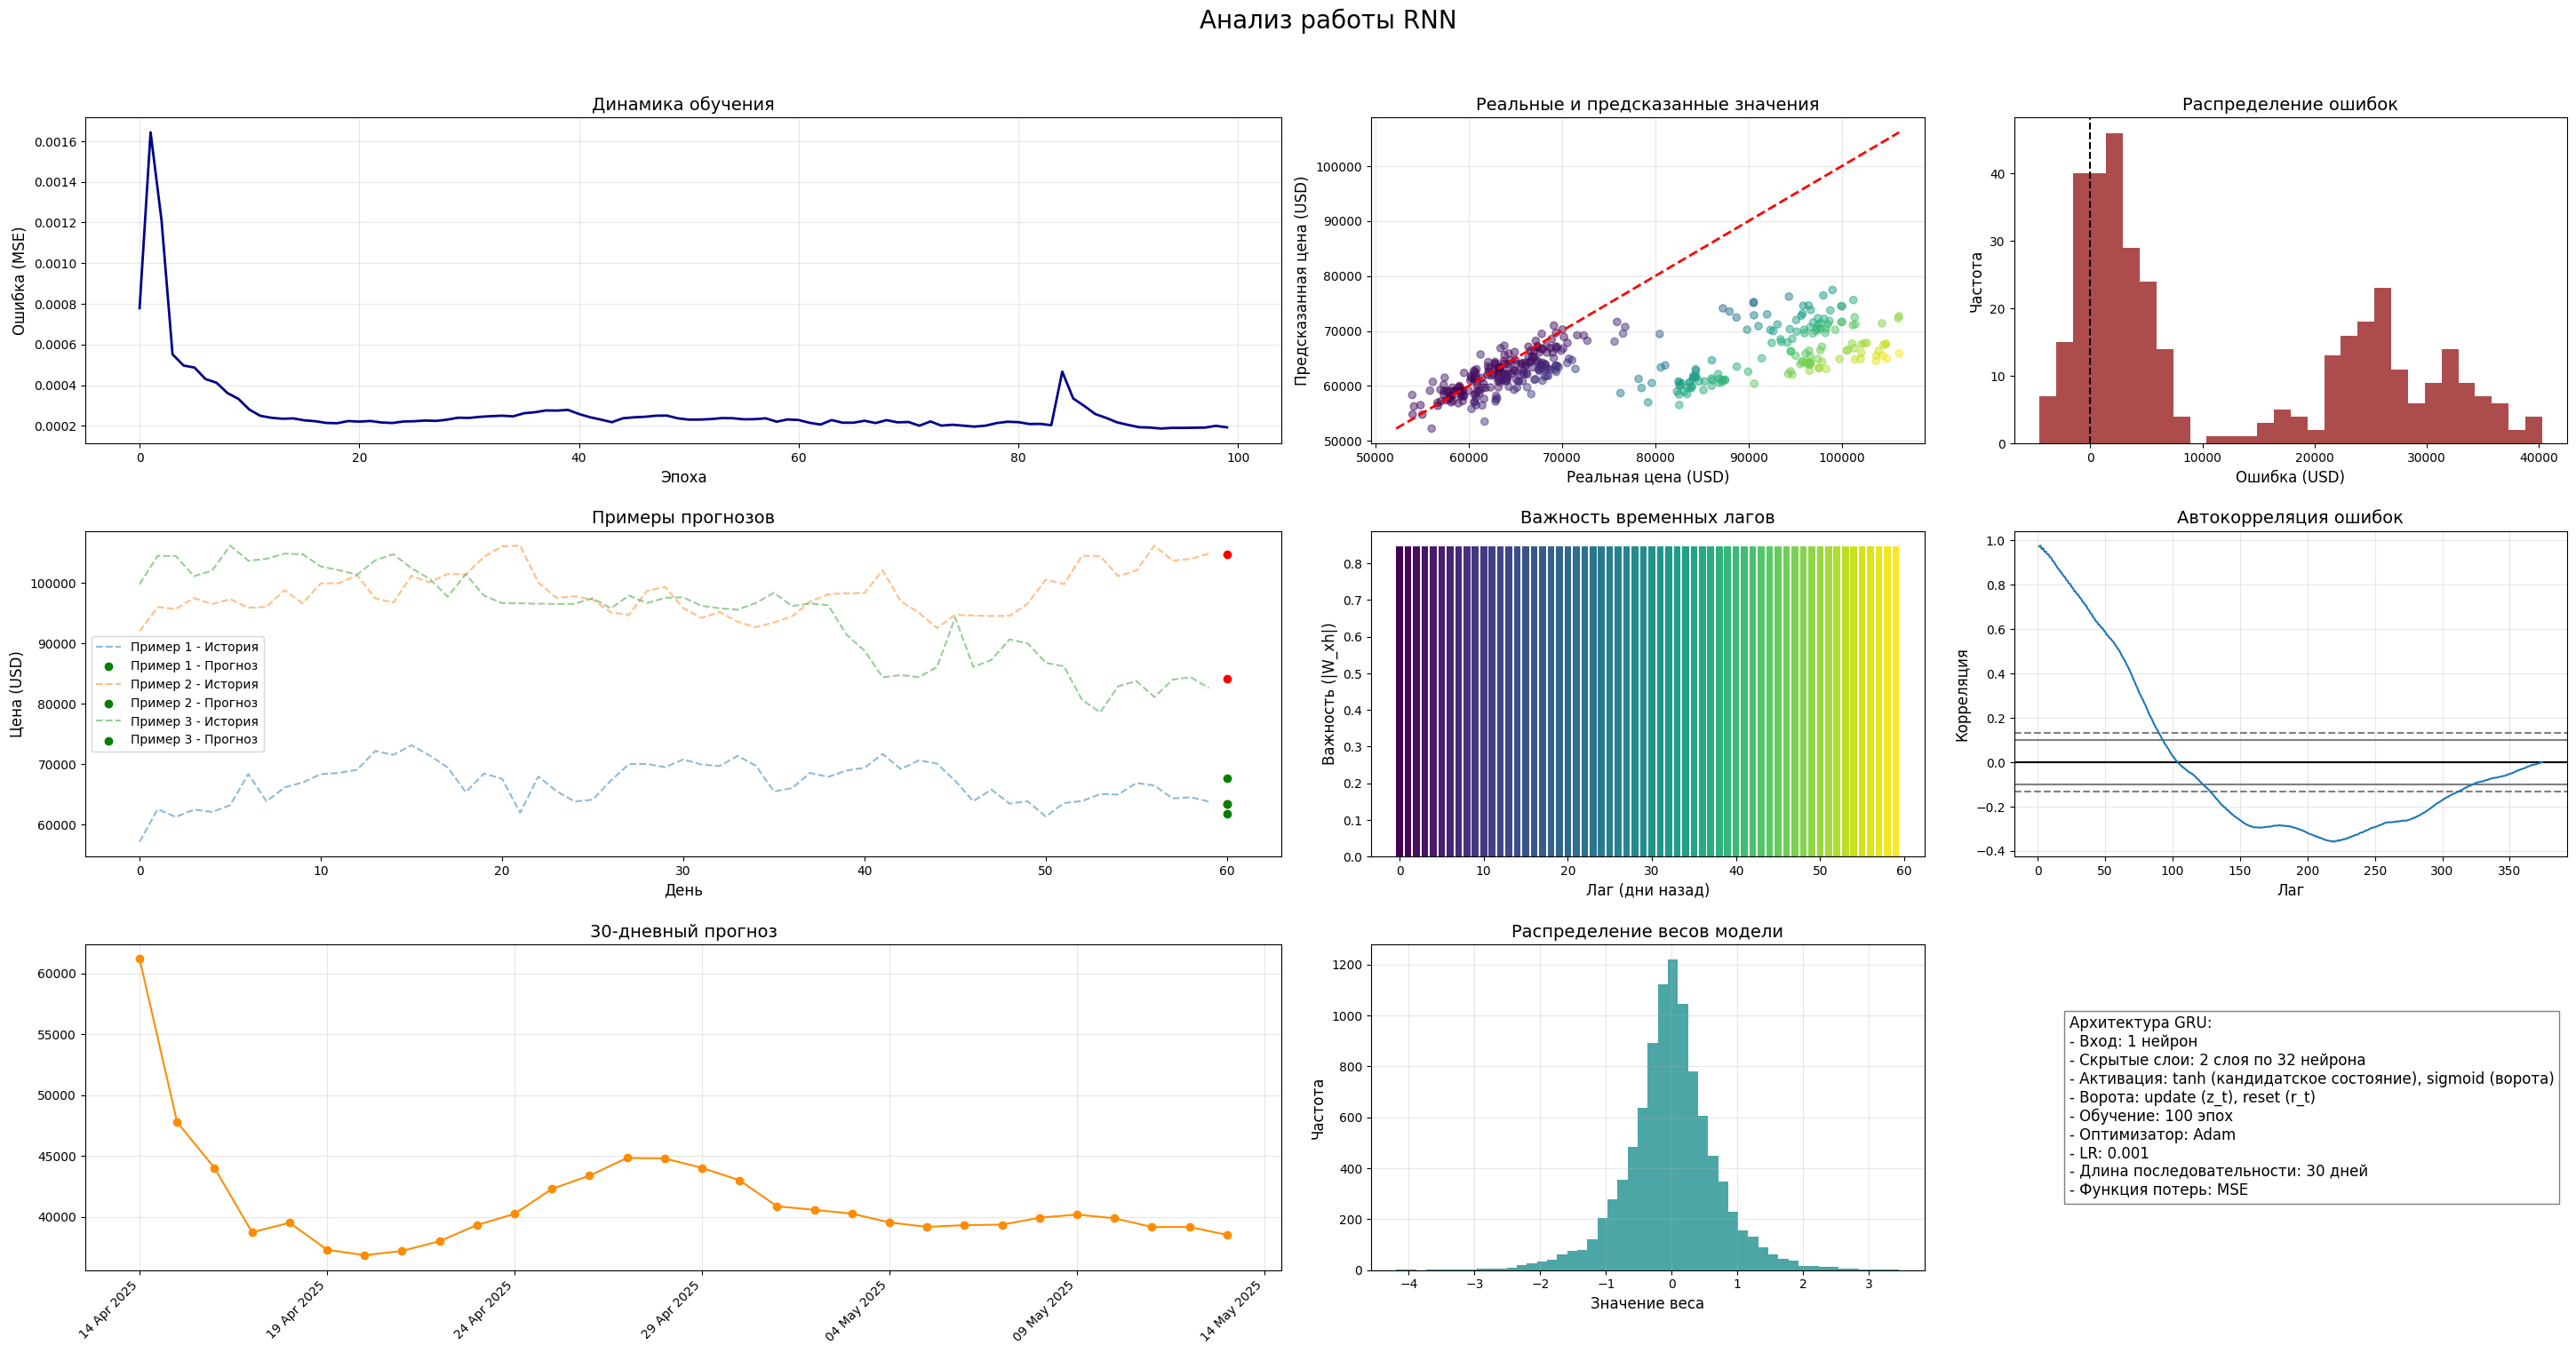

In [ ]:
# Определение GRU модели
class BitcoinGRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 32, num_layers = 2):
        super(BitcoinGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.inner_model = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, device=torch.device("cpu")):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=device).requires_grad_()
        out, hn = self.inner_model(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

# Инициализация модели
model = BitcoinGRU().to(device=device)

train_and_visualize(model, description=f"""Архитектура GRU:
- Вход: 1 нейрон
- Скрытые слои: 2 слоя по 32 нейрона
- Активация: tanh (кандидатское состояние), sigmoid (ворота)
- Ворота: update (z_t), reset (r_t)
- Обучение: {epochs} эпох
- Оптимизатор: Adam
- LR: {lr}
- Длина последовательности: 30 дней
- Функция потерь: MSE""", is_lstm=True)

Общие выводы:
- В коде быыли исправлены мелкие ошибки: вычитание из оригинальных проскейленные данные; забытое распространения ошибки в одной из `RNN` и т.д.
- Некоторые ошибки не были исправлены, т.к. они особо не повлияли на результат.
  - градиенты по функции потерь в `RNN` добавляются все в самом начале (перед обратных распространением через врата), что приводит к тому, что градиен от первого предсказания будет столь же значим, сколь и посдледний (будет прогнан через такое же число гейтов), что неверно. Все эти функции потерь стоит добавлять последовательно, с каждым шагом.
  - каждый новый прогноз строится из последовательности предыдущих. Наверное стоит его строить лишь по состоянию памяти на последний прогноз и новом прогнозе. Иными словами форкастить не на один симвоол вперед а сразу на несколько.
  - скейлить данные лучше всего не в начале, а, например, перед прогоном конкретной последовательности. Так у нас все промежутки будут иметь одинакового размера колебания и модель будет иметь б**о**льшую обощающую способность, а лосс будет считаться не по абсолюным значениям, а по относительным.
- `RNN` в целом показала хороший результат. Дальнейшее обучение позволит выйти на диагональную прямую. Также стоит заметить, что в варианте `truncated` скорость выросла, а качество осталось на уровне.
- `LSTM` и `GRU` показали не очень хороший результат. Во многом это связано с тем, что моедли очень быстро переобучаются на непиковых данных (из-за малого числа параметров), что приводит к тому, что её прогнозы не столь хороши на больших числах. Полечить это можно методом, озвученным ранее - через скейлинг последовательности, а не всей обучающей выборки.
- Допольнительно стоит отметить, что в настоящее время биткоин очень сильно зависит от инфоповодов в определенных сферах из-за чего предсказание его цены по графикам не супер успешная затея (не стоит ожидать скора в 1).